In [2]:
import rospy
from sensor_msgs.msg import PointCloud2
import sensor_msgs.point_cloud2 as pc2
from tf.transformations import rotation_matrix
import numpy as np
import cv_bridge 
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
import requests
import torch
import numpy as np
from PIL import Image,ImageDraw
from transformers import OwlViTProcessor, OwlViTForObjectDetection

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### UCN

In [3]:
perception = "/home/rilab-ur/UnseenObjectClustering"

In [4]:
CAPTURE = True

object_num = 4

if CAPTURE:
    if os.path.exists(f"{perception}/label_data.npy"):
        os.remove(f"{perception}/label_data.npy")

    if os.path.exists(f"{perception}/depth_data.npy"):
        os.remove(f"{perception}/depth_data.npy")

    if os.path.exists(f"{perception}/rgb_data.npy"):
        os.remove(f"{perception}/rgb_data.npy")

    subprocess.run([f"cd {perception}; ./experiments/scripts/ros_seg_rgbd_add_test_segmentation_realsense.sh 0 {object_num}"], shell=True)


+ set -e
+ export PYTHONUNBUFFERED=True
+ PYTHONUNBUFFERED=True
+ export CUDA_VISIBLE_DEVICES=0
+ CUDA_VISIBLE_DEVICES=0
+ outdir=data/checkpoints
+ ./ros/test_images_segmentation.py --gpu 0 --network seg_resnet34_8s_embedding --pretrained data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth --pretrained_crop data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth --cfg experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml --nums 4
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Called with args:
Namespace(background_name=None, cfg_file='experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml', dataset_name='shapenet_scene_train', gpu_id=0, instance_id=0, network_name='seg_resnet34_8s_embedding', nums=4, pretrained='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_sampling_epoch_16.checkpoint.pth', pretrained_crop='data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth', randomize=False)
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'tabletop_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'RGBD',
 'INTRINSICS': [],
 'MODE': 'TRAIN',
 'NETWORK': 'VGG16',
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POSE': '',
 'RIG': '',
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/rilab-ur/UnseenObjectClustering',
 'TEST': {'ALIGN_Z

KeyboardInterrupt: 

In [ ]:
label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 
rgb_pixel   = np.load(f'{perception}/rgb_data.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


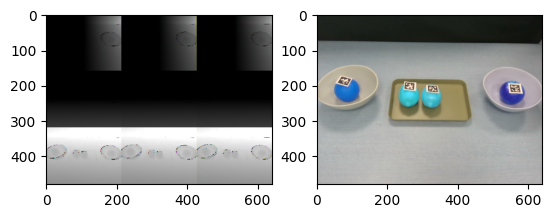

In [ ]:
plt.subplot(1,2,1)
plt.imshow(depth_pixel.reshape(480, 640,-1))
plt.subplot(1,2,2)
plt.imshow(rgb_pixel/255.0)
plt.show()

#### AprilTag

In [ ]:
def draw_bbox(results, image, intrinsic_matrix, verbose_bbox=False, plot_img=True):
    width = 640
    height = 480

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose_bbox:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        # cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

    if plot_img:
        plt.imshow(image)
        plt.show()


In [5]:
import apriltag
import cv2
import copy

label_pixel = np.load(f'{perception}/label_data.npy')
depth_pixel = np.load(f'{perception}/depth_data.npy') 
rgb_pixel   = np.load(f'{perception}/rgb_data.npy')

intrinsic_matrix = np.array([605.1119995117188, 0.0, 318.9336242675781, 0.0, 605.0845336914062, 237.35731506347656, 0.0, 0.0, 1.0])
cam_params = [intrinsic_matrix[0], intrinsic_matrix[4], intrinsic_matrix[2], intrinsic_matrix[5]]

detector = apriltag.Detector()
color_image = rgb_pixel
img_BGR = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
img_Gray = img_Gray.astype(np.uint8)

img_copy = color_image.copy()
results = detector.detect(img_Gray)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rilab-ur/UnseenObjectClustering/label_data.npy'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


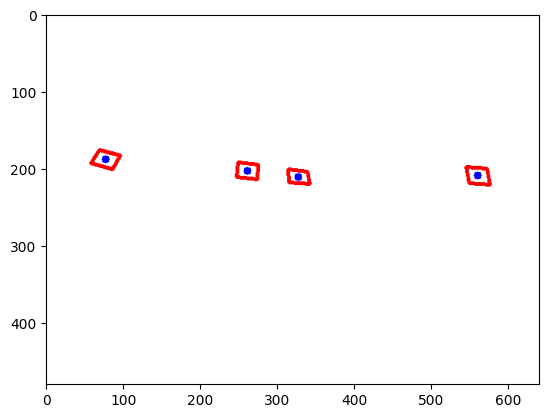

In [ ]:
img_copy = copy.deepcopy(rgb_pixel)
draw_bbox(results, color_image, intrinsic_matrix=intrinsic_matrix, verbose_bbox=False, plot_img=True)


In [6]:
import math 
import sys 
sys.path.append("../../../")
from utils.util_fk import *
print("Done.")

# Calibration
rotation_x   = Rotation_X(-math.pi)
rotation_y   = Rotation_Y(-math.pi/4)
rotation_mat = np.dot(rotation_x, rotation_y)
position_mat = Translation(0.454,0,1.3)
transform_mat= HT_matrix(rotation_mat, position_mat)

pose_list = []
for i in range(len(results)):
    ht_mat, e0, e1 = detector.detection_pose(detection=results[i], camera_params=cam_params, tag_size=0.03)    # should check tag_size
    position = t2p(ht_mat)
    recoordinate_position = [position[2], position[0], -position[1]]
    calibrated_mat = np.dot(transform_mat, np.append(recoordinate_position, 1))
    real_mat = calibrated_mat.T
    xyz = real_mat[0:3]
    print("xyz:\n", xyz)
    pose_list.append(xyz)

Done.


NameError: name 'results' is not defined

In [ ]:
pose_np = np.array(pose_list)
sorted_pose = np.sort(pose_np, axis=0)
print(np.sort(pose_np, axis=0))

[[ 0.88696193 -0.27462257  0.79068085]
 [ 0.909192   -0.01016374  0.79130559]
 [ 0.91500955  0.0641028   0.79231743]
 [ 0.91762541  0.26524966  0.79725357]]


In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


#### without shelf: flavor similarity

In [2]:
xml_path = '../../../asset/scene_realworld_wo_shelf_flavor.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-5,0.80,0])

# Place objects
tray_pos = np.array([ 0.9, 0.2, 0.8])
tray_gray_pos = np.array([ 0.9, -0.2, 0.8])
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_gray_pos
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 0])))
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 0])))

env.model.joint(env.model.body('coke').jntadr[0]).qpos0[:3] = tray_pos + np.array([-5,-0.05,0.15])
env.model.joint(env.model.body('cider').jntadr[0]).qpos0[:3] = tray_pos + np.array([-0.05,-0.05,0.15])
env.model.joint(env.model.body('redbullcan').jntadr[0]).qpos0[:3] = tray_pos + np.array([0.0,0.05,0.02])
env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = tray_gray_pos + np.array([0.0,0.05,0.02])
env.model.joint(env.model.body('ycb-lemon-2').jntadr[0]).qpos0[:3] = tray_gray_pos + np.array([0.0,-0.05,0.02])

# Target objects
env.model.joint(env.model.body('fanta_grape').jntadr[0]).qpos0[:3] = np.array([0.1,-0.6,0.85])
env.model.joint(env.model.body('ycb-orange').jntadr[0]).qpos0[:3] = np.array([0.2, -0.6, 0.8])

window


In [3]:

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=100):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[ 0.35 -0.13  1.16]


#### with shelf: category

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
xml_path = '../../../asset/scene_realworld_w_shelf_category.xml'
# xml_path = '../../../asset/scene_realworld_w_shelf_category_ver2.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-5,0.80,0])

shelf_pos = np.array([0.9,0.0,0.8])
env.model.body('shelf_row1').pos = shelf_pos

# Place objects
tray_pos = shelf_pos + np.array([ 0.05, -0.12, 0.20])
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[:3] = np.array([-5,1,1])
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([-0.05,-0.05,0.05])
env.model.joint(env.model.body('ycb-orange-2').jntadr[0]).qpos0[:3] = tray_pos + np.array([-0.05,0.05,0.05])
env.model.joint(env.model.body('cider').jntadr[0]).qpos0[:3] = shelf_pos + np.array([-0.05,0.15,0.30])
env.model.joint(env.model.body('obj_wine_01').jntadr[0]).qpos0[:3] = np.array([-2,1,1])
env.model.joint(env.model.body('fat_wine_glass').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0.0,0.15,0.02])
env.model.joint(env.model.body('fat_wine_glass').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 0])))
env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = shelf_pos + np.array([0.0,-0.1,0.03])
env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 90])))

env.model.joint(env.model.body('chocopie').jntadr[0]).qpos0[:3] = shelf_pos + np.array([-0.0,0.07,0.5])
env.model.joint(env.model.body('chocopie').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('pocky').jntadr[0]).qpos0[:3] = shelf_pos + np.array([-0.0,-0.07,0.5])
env.model.joint(env.model.body('pocky').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([-90, 90, 0])))

# Target objects
env.model.joint(env.model.body('ycb-lemon').jntadr[0]).qpos0[:3] = np.array([0.0, -0.6, 0.8])
env.model.joint(env.model.body('ycb-lemon').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, -90])))
env.model.joint(env.model.body('orange_can').jntadr[0]).qpos0[:3] = np.array([-0.05,-0.5,0.85])
env.model.joint(env.model.body('orange_can').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 135])))
# env.model.joint(env.model.body('obj_orange').jntadr[0]).qpos0[:3] = np.array([0.1,-0.6,0.85])
# env.model.joint(env.model.body('fanta_grape').jntadr[0]).qpos0[:3] = np.array([0.1,-0.6,0.85])
env.model.joint(env.model.body('pringles').jntadr[0]).qpos0[:3] = np.array([0.2, -0.6, 0.8])
env.model.joint(env.model.body('pringles').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 135])))

env.model.joint(env.model.body('ycb-apple').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('ycb-banana').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('ycb-orange').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('kitchen-bowl-red').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('kitchen-bowl-blue').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('redbullcan').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])
env.model.joint(env.model.body('coke').jntadr[0]).qpos0[:3] = np.array([-5,-5,1])


window


In [7]:
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx not in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [6, 7, 8, 9, 10, 11]


In [8]:
q_open = np.array([-0.33, -0.3 , -0.34,  0.38,  0.34,  0.36])

In [9]:

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-90,lookat=[0.9,0.0,1.51],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
# env.forward(q=q_open, joint_idxs=np.array([6,7,8,9,10,11]))
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

q_open =  np.array([1])
while env.get_sim_time() <= max_sec:
    ctrl = np.concatenate([init_ur_q, q_open])
    ctrl_idxs = [0,1,2,3,4,5,6]
    env.step(ctrl=ctrl,ctrl_idxs=ctrl_idxs)
    # env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=100):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[0.5  0.   1.14]
Pressed ESC
Quitting.


### OWL-ViT

In [ ]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# image_np = np.load('./image/rgb_data.npy')
image = cv2.cvtColor(rgb_pixel, cv2.COLOR_RGB2BGR)
image = Image.fromarray(image.astype('uint8'), 'RGB')
# convert RGB to BGR

texts = [["a photo of a orange", "a photo of a apple", "a photo of a banana", "a photo of a pringles", "a photo of a choco-pie",
          "a photo of a glass", "a photo of a Fanta", "a photo of a Coke", "a photo of a Redbull"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo of a orange with confidence 0.112 at location [48.3, 178.27, 120.4, 248.71]
Detected a photo of a orange with confidence 0.315 at location [49.5, 175.89, 120.2, 248.31]
Detected a photo of a apple with confidence 0.144 at location [231.66, 191.36, 287.83, 264.72]
Detected a photo of a apple with confidence 0.224 at location [296.42, 197.37, 353.07, 265.46]
Detected a photo of a apple with confidence 0.346 at location [518.09, 188.97, 587.82, 256.34]


In [ ]:

draw = ImageDraw.Draw(image)  # Create a drawing object for the image

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    # Draw bounding box on the image
    draw.rectangle(box, outline="red", width=2)
    text_info = f"{text[label]} : {round(score.item(), 3)}"
    draw.text((box[0], box[1]), text_info, fill="red")

image.show()  # Display the image with bounding boxes and labels


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
